## **Introduction**
Feature Engineering is a critical step in the machine learning pipeline where we transform raw data into meaningful features that enhance model performance. By improving the quality of the input data, feature engineering directly impacts the accuracy, interpretability, and efficiency of the machine learning models.

In this notebook, we will:
- Analyze and refine features derived from the dataset.
- Create new features that better represent the underlying patterns in the data.
- Handle issues such as missing values, outliers, and feature scaling.
- Encode categorical variables and apply transformations to numerical features.

## **Objectives**
1. **Prepare Data for Modeling**: Ensure the data is in a format suitable for training machine learning models.
2. **Improve Predictive Power**: Engineer features that strengthen the relationship between the predictors and the target variable.
3. **Reduce Complexity**: Simplify the dataset by combining or transforming features where necessary.
4. **Handle Data Issues**: Address challenges such as skewness, multicollinearity, and missing values.

## **Scope**
This notebook focuses on applying feature engineering techniques to the cleaned dataset, following the insights gained during the Exploratory Data Analysis (EDA) phase. The steps performed here will create a final dataset ready for model training and evaluation.

---

## **Outline**
1. **Load and Split Data**: Load the cleaned dataset prepared during the EDA phase and make train-test split.
2. **Handle Outliers**: Identify and treat extreme values that can negatively affect model performance:
3. **Feature Creation**: Engineer new features based on domain knowledge and patterns in the data.
4. **Feature Encoding**: Encode categorical variables using techniques such as one-hot encoding or label encoding.
5. **Feature Transformation**: Apply scaling, normalization, and log transformations to appropriate features.
6. **Feature Selection**: Identify and retain the most relevant features for modeling.

By the end of this notebook, we will have a well-prepared dataset optimized for building robust machine learning models.


## **1. Load Data**

In [1]:
# Import necessary libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
df = pd.read_csv('../../data/cleaned_data.csv')
df.head()

,id,price,levy,manufacturer,model,manufacturing_year,category,leather_interior,fuel_type,engine_volume,distance_travelled,cylinders,gear_box_type,drive_wheels,doors,drive_type,color,airbags
0,45654403,13328,1399,LEXUS,RX 450,2010-01-01,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011-01-01,Jeep,No,Petrol,3,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,8
2,45774419,8467,781,HONDA,FIT,2006-01-01,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011-01-01,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014-01-01,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,4


## **2. Handle Outliers**

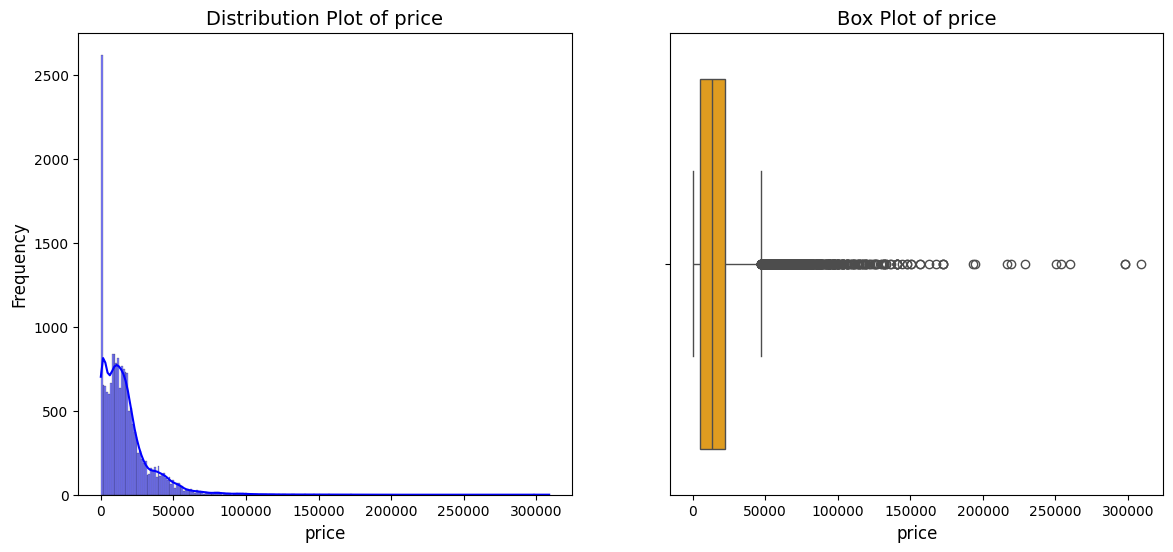

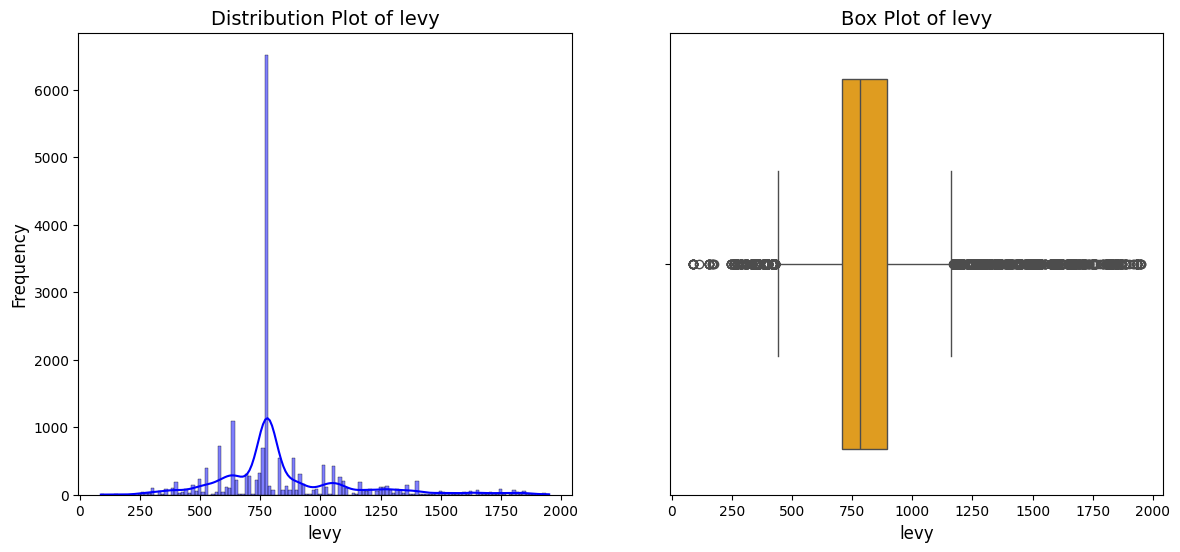

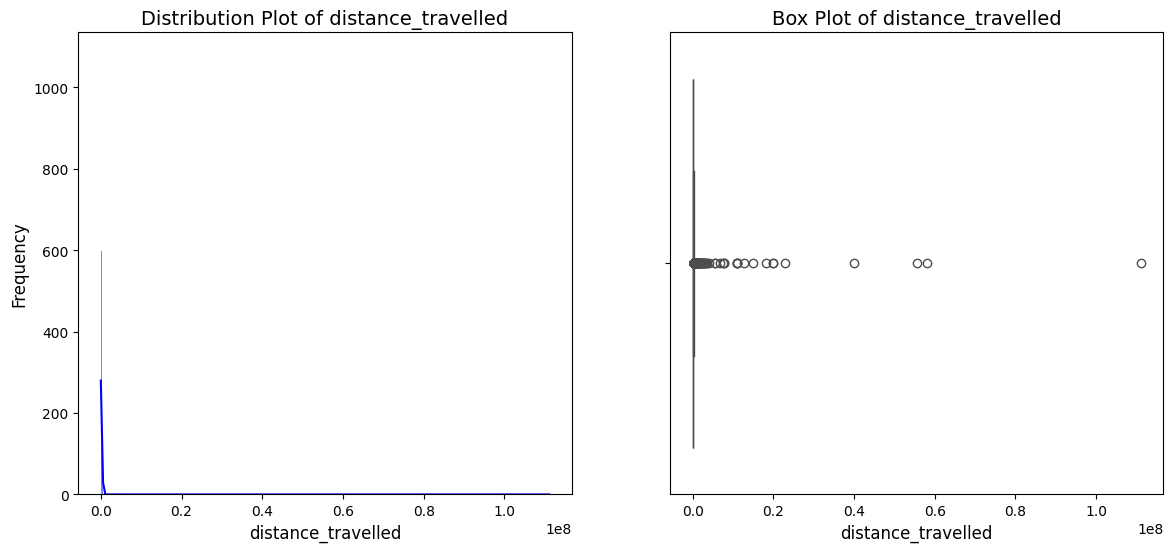

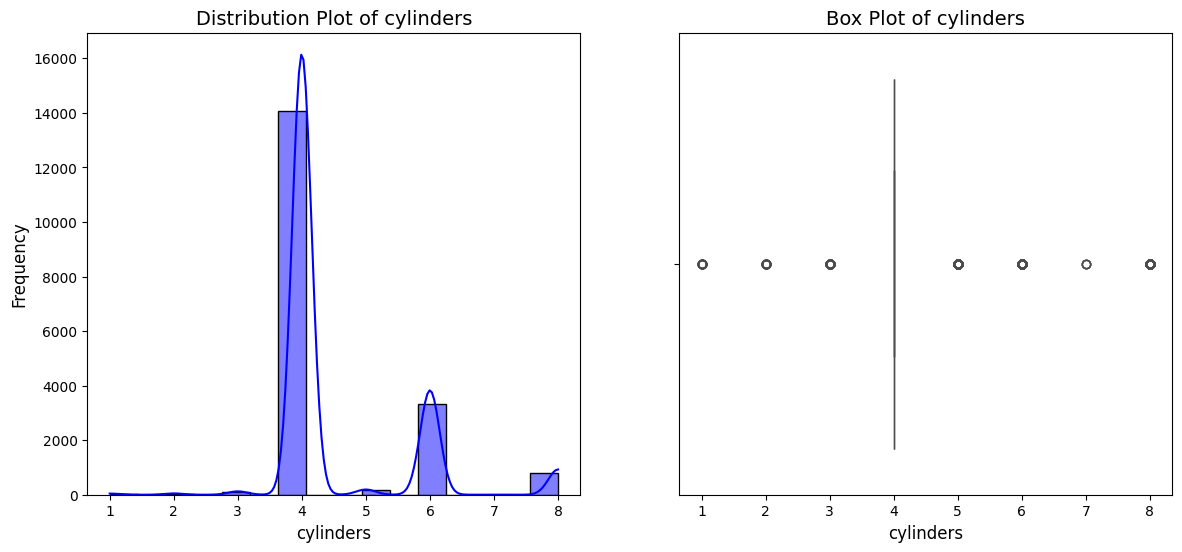

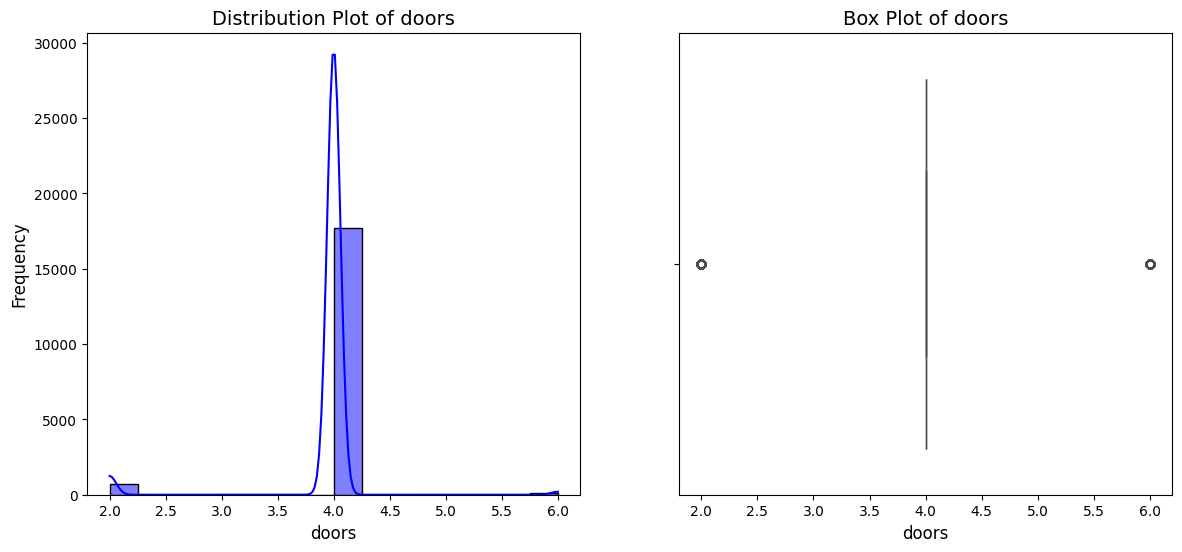

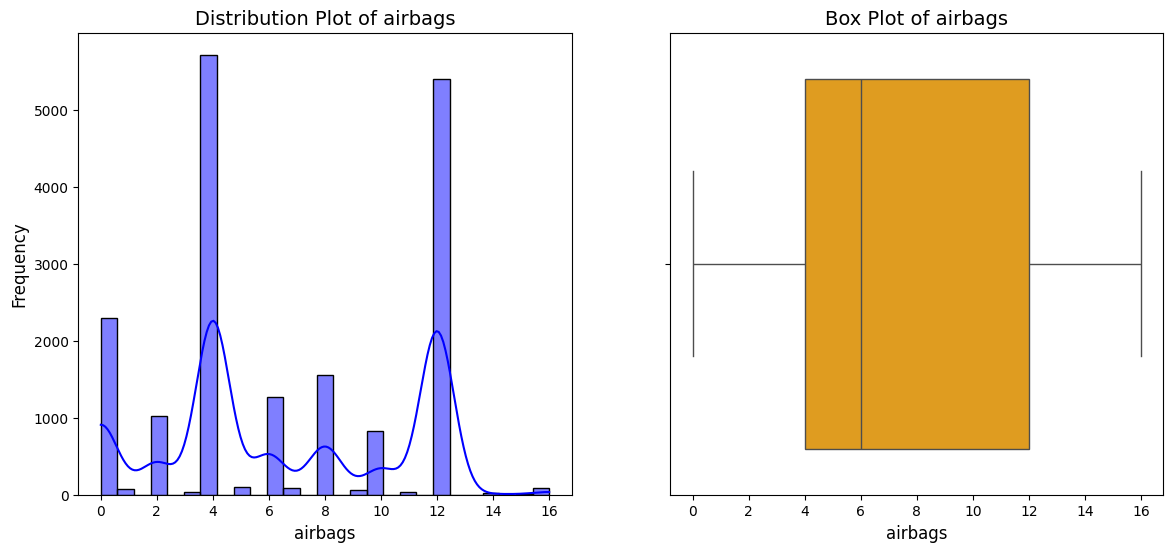

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for outliers in continuos features
numerical_columns = df.select_dtypes(include=['float64','int64']).columns.to_list()
numerical_columns.remove('id')
for col in numerical_columns:
        # Create a 1x2 subplot layout
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Distribution Plot
        sns.histplot(df[col], kde=True, ax=axes[0], color='blue')
        axes[0].set_title(f'Distribution Plot of {col}', fontsize=14)
        axes[0].set_xlabel(col, fontsize=12)
        axes[0].set_ylabel('Frequency', fontsize=12)

        # Box Plot
        sns.boxplot(data=df, x=col, ax=axes[1], color='orange')
        axes[1].set_title(f'Box Plot of {col}', fontsize=14)
        axes[1].set_xlabel(col, fontsize=12)	

### Observations

1. **Price**:
   - Contains some outliers.
   - The data is **right-skewed**.

2. **Distance Travelled**:
   - Contains **extreme outliers**.
   - The data is also **right-skewed**.

### How to Handle Outliers and Skewness?

#### Steps to Handle:
1. **Outlier Handling**:
   - **Price**: Use the **Interquartile Range (IQR)** method or **Winsorization** to cap extreme outliers.
   - **Distance Travelled**: **Quantile Binning**.
     
2. **Skewness Correction**:
   - Apply **log transformation** or **Box-Cox transformation** to reduce right skewness.


In [4]:
# Removing outliers from price column using IQR method
Q1 = df['price'].quantile(0.25)  # First quartile (25th percentile)
Q3 = df['price'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1                        # Interquartile Range

lower_bound = Q1 - 1.5 * IQR         # Lower bound
upper_bound = Q3 + 1.5 * IQR         # Upper bound

# Filter out rows with outliers
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

Text(0.5, 0, 'price')

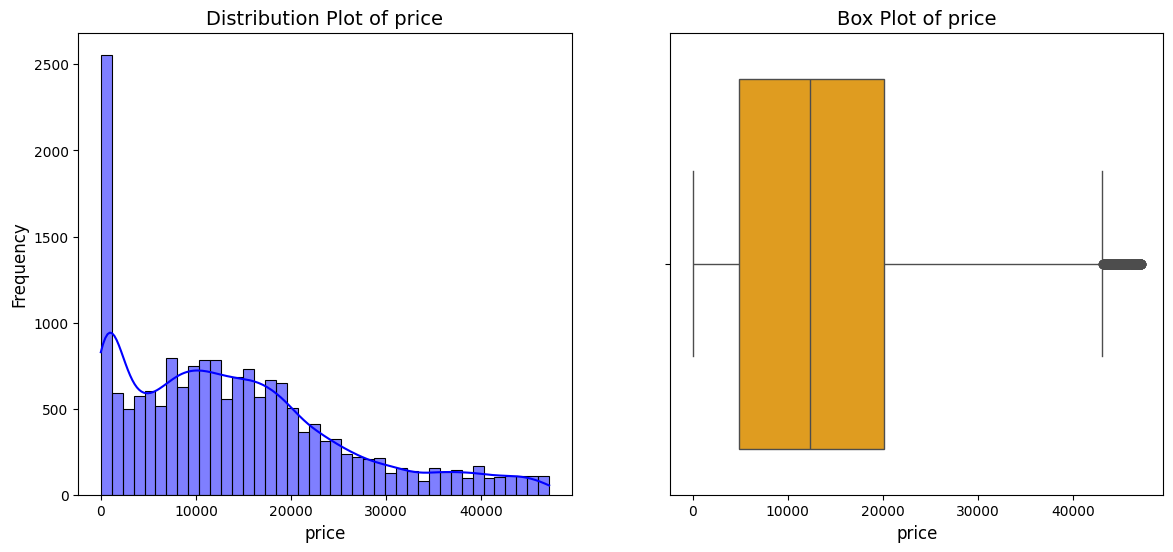

In [5]:
# Visulizing the price column after removing outliers

# Create a 1x2 subplot layout
col = 'price'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Distribution Plot
sns.histplot(df[col], kde=True, ax=axes[0], color='blue')
axes[0].set_title(f'Distribution Plot of {col}', fontsize=14)
axes[0].set_xlabel(col, fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Box Plot
sns.boxplot(data=df, x=col, ax=axes[1], color='orange')
axes[1].set_title(f'Box Plot of {col}', fontsize=14)
axes[1].set_xlabel(col, fontsize=12)

## **3. Feature Creation**

Feature engineering allows us to derive new insights from the existing data and improve the performance of our machine learning models. Below are the new features created for our analysis:

### **1. Turbo Indicator**
- **Description**: The `engine_volume` column contains information about the engine capacity, with some values also indicating the presence of a turbo (e.g., "2.0 Turbo"). 
- **Transformation**:
  - Extract a new binary feature `turbo` to indicate whether the car is equipped with a turbocharger (`1` for turbo, `0` for non-turbo).
  - Convert `engine_volume` to a float64 datatype for consistency.

### **2. Car Age**
- **Description**: The `manufacturing_year` column provides the production year of each car. 
- **Transformation**:
  - Create a new column `car_age` by subtracting the manufacturing year from the current year (`car_age = current_year - manufacturing_year`).
  - This feature helps capture the impact of car age on price, as older cars tend to depreciate.

In [6]:
# create turbo feature 
df['turbo'] = df['engine_volume'].str.contains('Turbo', case=False, na=False).astype(int)
df['turbo']

0        0
1        0
2        0
3        0
4        0
        ..
18577    1
18578    0
18579    0
18580    0
18581    0
Name: turbo, Length: 17557, dtype: int64

In [7]:
# change the dtype of engine_volume to float_64
df['engine_volume'] = df['engine_volume'].str.replace('Turbo', '', case=False).astype(float)
df['engine_volume']

0        3.5
1        3.0
2        1.3
3        2.5
4        1.3
        ... 
18577    2.0
18578    2.4
18579    2.0
18580    2.0
18581    2.4
Name: engine_volume, Length: 17557, dtype: float64

In [8]:
# Convert year to numeric, forcing errors to NaN
df['manufacturing_year'] = pd.to_datetime(df['manufacturing_year'], errors='coerce').dt.year
df['manufacturing_year']

0        2010
1        2011
2        2006
3        2011
4        2014
         ... 
18577    1999
18578    2011
18579    2010
18580    2007
18581    2012
Name: manufacturing_year, Length: 17557, dtype: int32

In [9]:
from datetime import datetime

# Calculate car_age
current_year = datetime.now().year
df['car_age'] = current_year - df['manufacturing_year']
df['car_age']

0        14
1        13
2        18
3        13
4        10
         ..
18577    25
18578    13
18579    14
18580    17
18581    12
Name: car_age, Length: 17557, dtype: int32

In [10]:
df.head()

,id,price,levy,manufacturer,model,manufacturing_year,category,leather_interior,fuel_type,engine_volume,distance_travelled,cylinders,gear_box_type,drive_wheels,doors,drive_type,color,airbags,turbo,car_age
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4,Left wheel,Silver,12,0,14
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,8,0,13
2,45774419,8467,781,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2,0,18
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,0,0,13
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,4,0,10


## **4. Feature Encoding**


### **Binning `distance_travelled`**

To simplify the `distance_travelled` feature, we grouped it into three categories:

- **Low**: Cars with distance ≤ 50,000 km.
- **Medium**: Cars with distance between 50,000 km and 150,000 km.
- **High**: Cars with distance > 150,000 km.

This binning process helps capture non-linear relationships and reduces the impact of outliers.

In [11]:
# Binnig distance travelled

# Use qcut for quantile-based binning

labels = ['low', 'medium', 'high']

df['distance_travelled_group'] = pd.qcut(df['distance_travelled'], q=3, labels=labels, duplicates='drop')

df['distance_travelled_group']

0          high
1          high
2          high
3          high
4           low
          ...  
18577      high
18578    medium
18579    medium
18580       low
18581      high
Name: distance_travelled_group, Length: 17557, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [12]:
# Split the data into train-test split to avoid data leakage
train_df, test_df = train_test_split(df,test_size=0.2,random_state=42)

In [13]:
# Apply Label encoding 
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_df['distance_travelled_group'] = encoder.fit_transform(train_df['distance_travelled_group'])
test_df['distance_travelled_group'] = encoder.transform(test_df['distance_travelled_group'])

In [14]:
# Encoding manufacturer using target based encoding 
manufacturer_price_mean = train_df.groupby('manufacturer')['price'].mean()
train_df['manufacturer_encoded'] = train_df['manufacturer'].map(manufacturer_price_mean)
test_df['manufacturer_encoded'] = test_df['manufacturer'].map(manufacturer_price_mean)
train_df['manufacturer_encoded']

12877    12746.952348
16843     8545.879699
9402     12404.123853
14374    12754.132569
1821     11261.809052
             ...     
11945    11384.817156
12668    12754.132569
5690     12754.132569
912      11928.171053
16734    11384.817156
Name: manufacturer_encoded, Length: 14045, dtype: float64

In [15]:
# Target-based encoding for model column
model_price_mean = train_df.groupby('model')['price'].mean()

train_df['model_encoded'] = train_df['model'].map(model_price_mean)
test_df['model_encoded'] = test_df['model'].map(model_price_mean)

In [16]:
df.category.value_counts()

category
Sedan          8218
Jeep           4590
Hatchback      2765
Minivan         605
Coupe           464
Universal       333
Microbus        283
Goods wagon     223
Pickup           38
Cabriolet        27
Limousine        11
Name: count, dtype: int64

In [17]:
# Group rare categories
category_threshold = 300
train_df['category_grouped'] = train_df['category'].apply(
    lambda x: x if train_df['category'].value_counts()[x] >= category_threshold else 'Other'
)
test_df['category_grouped'] = test_df['category'].apply(
    lambda x: x if train_df['category'].value_counts()[x] >= category_threshold else 'Other'
)

In [18]:
# Target-based encoding
category_price_mean = train_df.groupby('category_grouped')['price'].mean()
train_df['category_encoded'] = train_df['category_grouped'].map(category_price_mean)
test_df['category_encoded'] = test_df['category_grouped'].map(category_price_mean)

In [19]:
# Map 'Yes' to 1 and 'No' to 0 for column leather_interios
train_df['leather_interior_encoded'] = train_df['leather_interior'].map({'Yes': 1, 'No': 0})
test_df['leather_interior_encoded'] = test_df['leather_interior'].map({'Yes': 1, 'No': 0})


In [20]:
# Grouping fuel_type
# Define a threshold for rare categories
threshold = 100
fuel_counts = train_df['fuel_type'].value_counts()

# Replace rare categories with 'Other'
train_df['fuel_type_grouped'] = train_df['fuel_type'].apply(
    lambda x: x if fuel_counts[x] >= threshold else 'Other'
)
test_df['fuel_type_grouped'] = test_df['fuel_type'].apply(
    lambda x: x if x in fuel_counts[fuel_counts >= threshold] else 'Other'
)


In [21]:
# Apply Label encoding 
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_df['fuel_type_encoded'] = encoder.fit_transform(train_df['fuel_type_grouped'])
test_df['fuel_type_encoded'] = encoder.transform(test_df['fuel_type_grouped'])

In [ ]:
# One-Hot Encode `drive_wheels` and `drive_type`
train_df = pd.get_dummies(train_df, columns=['drive_wheels', 'drive_type'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['drive_wheels', 'drive_type'], drop_first=True)

# Label Encode `gear_box_type`
label_encoder = LabelEncoder()
train_df['gear_box_type_encoded'] = label_encoder.fit_transform(train_df['gear_box_type'])
test_df['gear_box_type_encoded'] = label_encoder.transform(test_df['gear_box_type'])

In [23]:
# Group rare colors into "Other" if frequency is below a threshold (e.g., 1%)
threshold = 0.01  # 1%
color_counts = train_df['color'].value_counts(normalize=True)
rare_colors = color_counts[color_counts < threshold].index
train_df['color'] = train_df['color'].replace(rare_colors, 'Other')

# Frequency Encoding
color_frequency = train_df['color'].value_counts(normalize=True)
train_df['color_encoded'] = train_df['color'].map(color_frequency)

## **5. Feature Transformation**


In [24]:
# Scale numerical features using StandardScaler
from sklearn.preprocessing import StandardScaler

# List of numerical columns to scale
columns_to_scale = ['engine_volume','levy','cylinders','doors','airbags','car_age','manufacturer_encoded','model_encoded','category_encoded']  # Update as needed

# Initialize scaler
scaler = StandardScaler()

# Scale selected columns
train_df[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
test_df[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

In [25]:
# Drop unnecessary columns
columns_to_drop = ['id','manufacturer','model','manufacturing_year','category','leather_interior','fuel_type','distance_travelled','gear_box_type','color','category_grouped','fuel_type_grouped']

train_df.drop(columns=columns_to_drop,inplace=True)
test_df.drop(columns=columns_to_drop,inplace=True)

In [26]:
train_df.head()

,price,levy,engine_volume,cylinders,doors,airbags,turbo,car_age,distance_travelled_group,manufacturer_encoded,model_encoded,category_encoded,leather_interior_encoded,fuel_type_encoded,drive_wheels_Front,drive_wheels_Rear,drive_type_Right-hand drive,gear_box_type_encoded,color_encoded
12877,627,1.231554,1.599943,1.446855,0.163704,1.258699,0,-0.050229,0,-0.313975,-0.610361,-0.605692,1,1,False,False,False,0,0.256034
16843,11290,-0.177605,0.074179,-0.467158,0.163704,-0.600109,0,0.306336,2,-1.350879,-0.398052,2.185256,0,5,True,False,False,2,0.073336
9402,32929,-0.177605,0.328473,-0.467158,0.163704,-1.064812,1,-0.050229,0,-0.398591,2.405317,0.894756,0,1,False,False,False,1,0.229619
14374,11917,1.087394,-0.942997,-0.467158,0.163704,1.258699,0,0.841183,2,-0.312203,-0.371593,-0.605692,0,5,True,False,False,0,0.034033
1821,6899,-0.177605,1.218502,1.446855,0.163704,-0.600109,0,2.267443,1,-0.680536,-1.107068,1.283651,0,5,False,False,False,0,0.229619


In [27]:
test_df.head()

,price,levy,engine_volume,cylinders,doors,airbags,turbo,car_age,distance_travelled_group,manufacturer_encoded,model_encoded,category_encoded,leather_interior_encoded,fuel_type_encoded,drive_wheels_Front,drive_wheels_Rear,drive_type_Right-hand drive,gear_box_type_encoded
17550,3763,-2.058886,-1.070144,-0.467158,0.163704,-1.529514,0,-0.585076,2,-0.028422,-0.694073,-1.113058,1,2,True,False,False,0
17207,16452,0.020614,-0.307262,-0.467158,0.163704,-0.600109,0,0.128054,2,1.228684,0.659901,0.273379,1,5,True,False,False,0
13271,26594,1.664032,0.964208,-0.467158,0.163704,-0.600109,0,-0.941641,0,1.228684,0.555010,-0.605692,1,3,True,False,False,0
5438,40,-0.177605,-0.942997,-0.467158,0.163704,-0.600109,0,0.484619,0,-0.312203,-0.371593,-1.113058,0,2,True,False,False,3
17545,9095,-0.177605,-1.197291,-0.467158,0.163704,-1.064812,0,1.910878,2,-0.312203,NaN,1.283651,0,5,False,True,True,0


In [28]:
# Save the training and test dataset
train_df.to_csv('../../data/train_data.csv',index=False)
test_df.to_csv('../../data/test_data.csv',index=False)